In [1]:
%load_ext autoreload
%autoreload 2
import torch
import imageio
import sys
import io
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
sys.path.append("../radialmri/")
from simulation_and_reconstruction import *

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
../radialmri/simulation_and_reconstruction.py:23: UserWarning: Out of sync with the remove repository
  warnings.warn('Out of sync with the remove repository')


In [2]:
filedir = '/gpfs/home/zh1115/knolllabspace/hzn/storage/newsimulation/simulated_20210128/sim_PT13.mat'
dataload = loadmat(filedir)
print(dataload.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ID', 'S0', 'aif', 'cts', 'mask', 'parMap', 'simImg', 'smap_complex'])


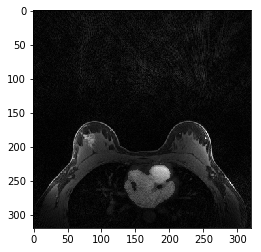

In [4]:
plt.imshow(np.abs(dataload['simImg'][:, :, 9]), cmap = 'gray')
plt.show()

In [5]:
masksloaded = dataload['mask']

simulated_image = dataload['simImg']
simulated_image = np.flipud(np.array(simulated_image))#flip up and down

simulated_target = np.array(simulated_image, dtype='complex128')
simulated_target = simulated_target.swapaxes(0, 2).swapaxes(1, 2)
#print(simulated_target.shape, simulated_target.dtype)

target = np.stack((simulated_target.real, simulated_target.imag), axis=1)
target = torch.tensor(target, dtype=dtype, device=device)


smap_complex = dataload['smap_complex']
smap_loaded = numpy2torch(smap_complex, device =device)
smap_loaded = smap_loaded.permute(1,0,2,3).unsqueeze(0)

nt = 22
temporal_coilimg = np.array([sim_coil(simulated_target[i,:,:], smap_complex, coild=0) for i in range(nt)])

target_recombine= np.array([temporal_coilimg[:,i]*np.conj(smap_complex[i,:,:]) for i in range(temporal_coilimg.shape[1])])
target_recombine= np.sum(target_recombine, axis=0)

In [6]:
print("target.shape", target.shape, target.dtype,\
      "smap.shape", smap_loaded.shape, smap_loaded.dtype)

simulated_kspace_21, recon_fromsim_21, traj_21, dcomp_21 \
= RadialSimulation(target = target,
                   spokespertime=21,
                   nt=nt, nc=16,
                   spokelength=640,
                   smap=smap_loaded,
                   grid_size = (640, 640),
                   im_size= (320, 320))

recon_fromsim_21 = torch2numpy(recon_fromsim_21.permute(0,2,3,1))

target.shape torch.Size([22, 2, 320, 320]) torch.float32 smap.shape torch.Size([1, 16, 2, 320, 320]) torch.float32
torch.Size([22, 16, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


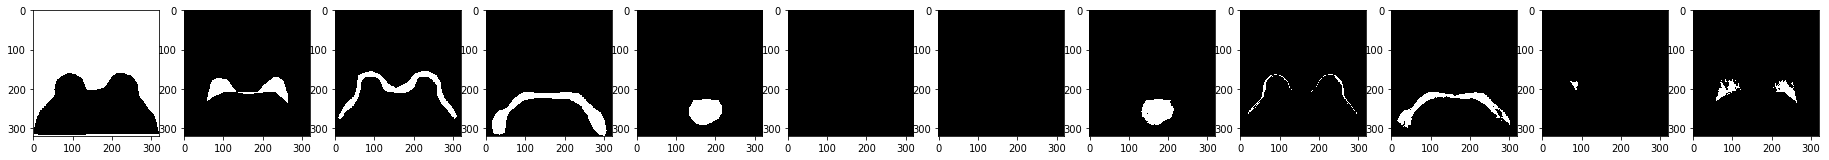

In [7]:
plotcoil(masksloaded[0][0], n = 12, cmap = 'gray')

## Original Density Compensation

torch.Size([22, 2, 320, 320])


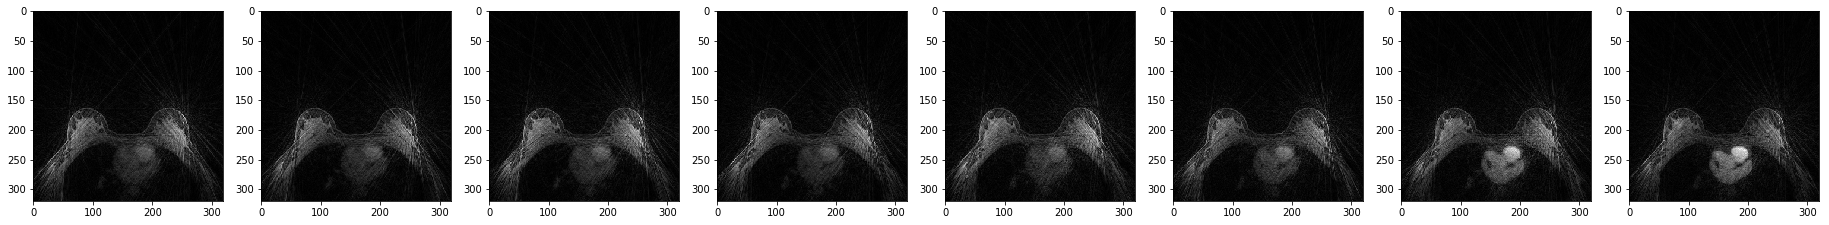

(22,)


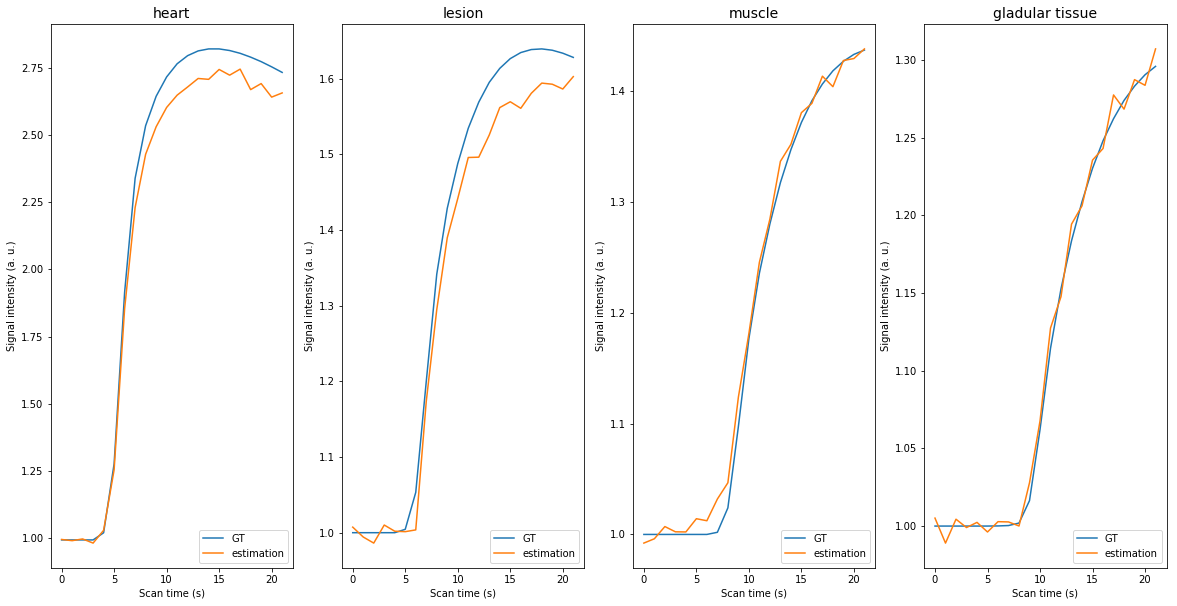

In [8]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_21.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_21.to(device))

print(adj_nufft.shape)
adjnufft = torch.sqrt(adj_nufft[:, 0]**2 + adj_nufft[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Updated Density Compensation

In [9]:
def dcomp_reference(traj, nt = 22, nc = 1):
    dcomp = torch.sqrt(traj[0, 0]**2 + traj[0, 1]**2)
    dcomp = dcomp / max(dcomp)
    dcomp = dcomp.repeat(nt, nc, 2, 1)
    return dcomp

dcomp_FL = dcomp_reference(traj_21, nt = 22, nc = 16)
print(dcomp_FL.shape, dcomp_FL.device)

torch.Size([22, 16, 2, 13440]) cpu


torch.Size([22, 2, 320, 320])


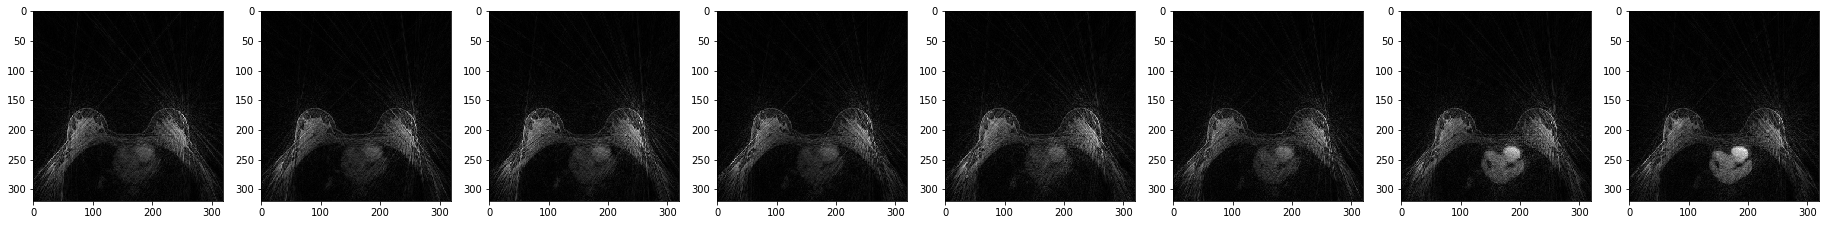

(22,)


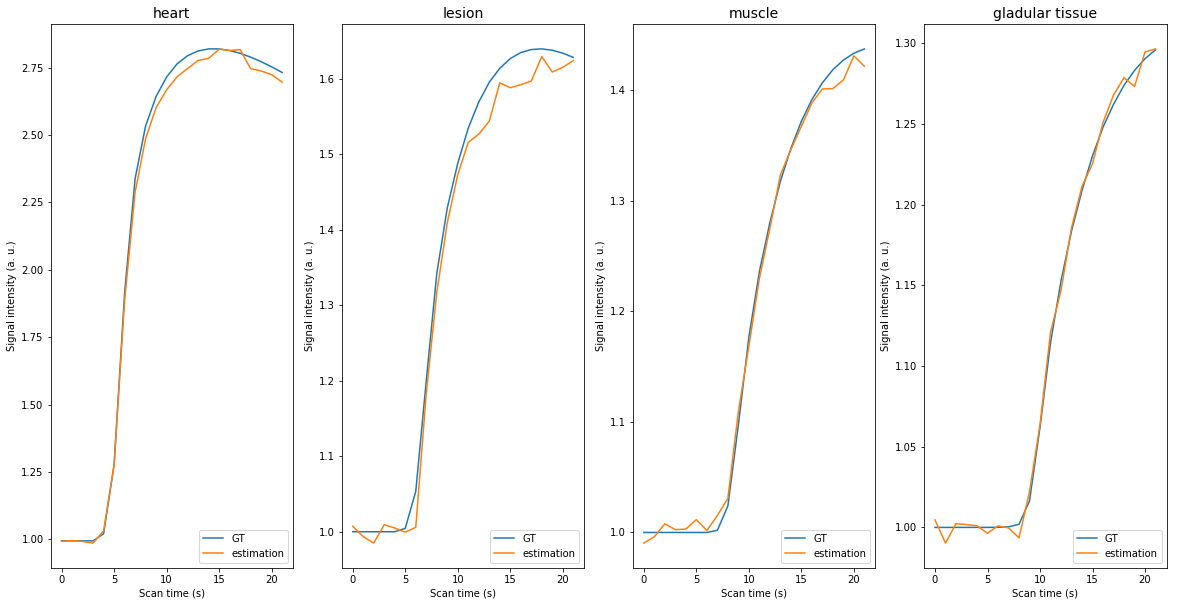

In [10]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_FL.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

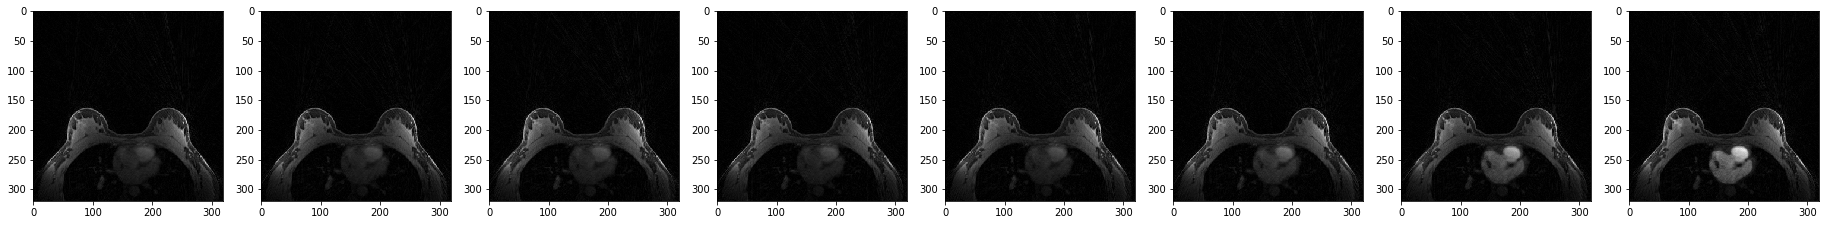

(22,)


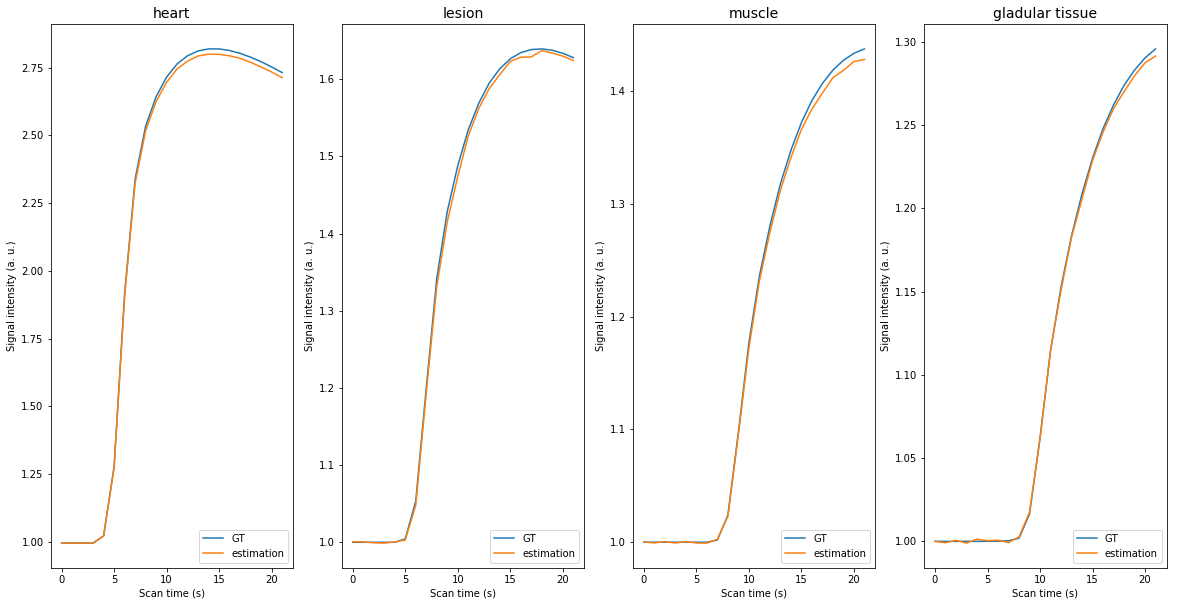

In [11]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5',
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

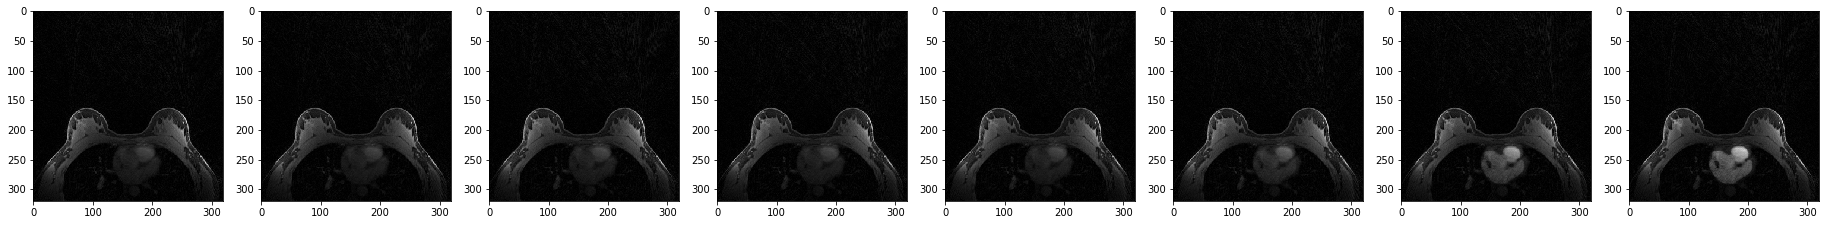

(22,)


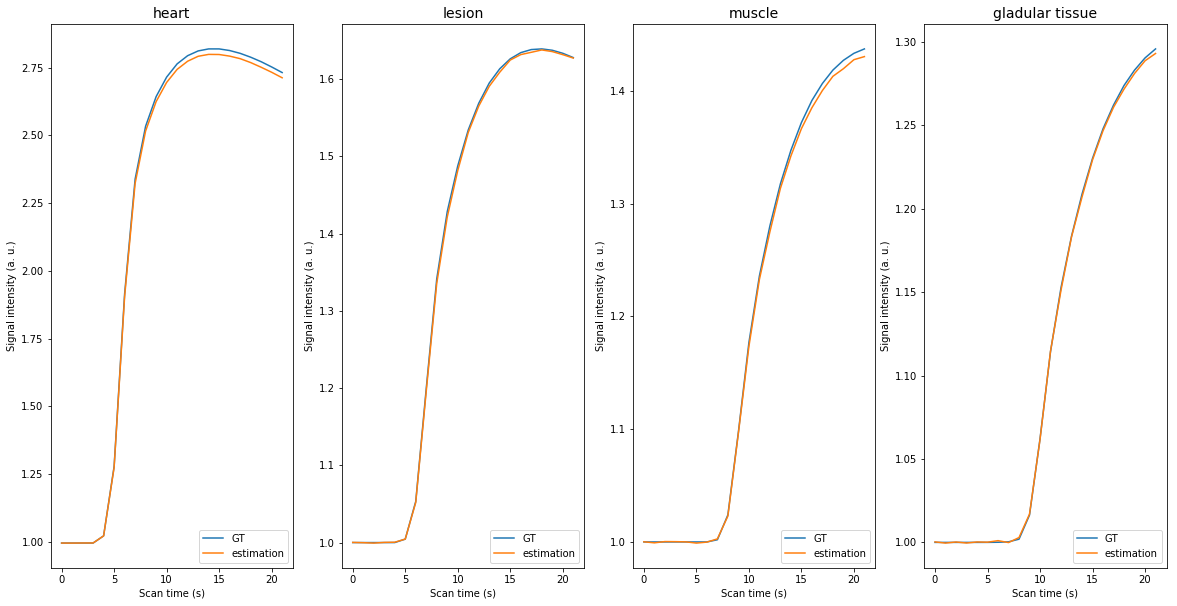

In [13]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5',
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Using the original density compensation

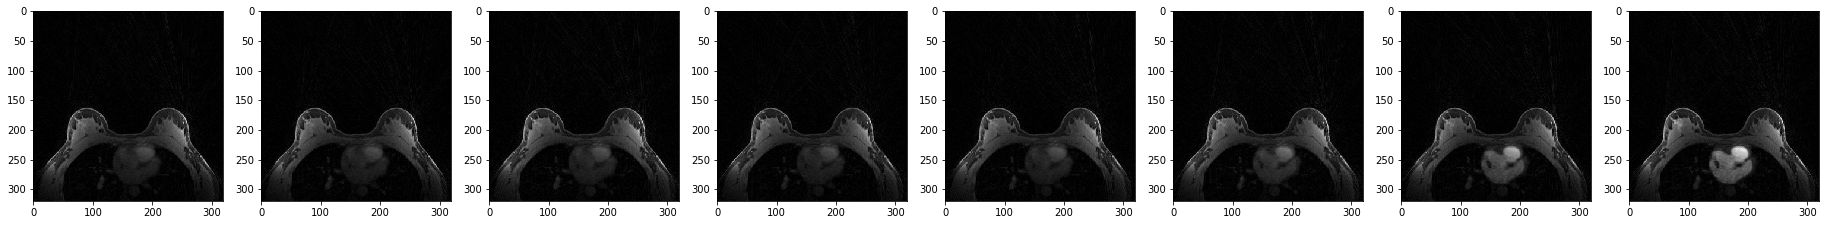

(22,)


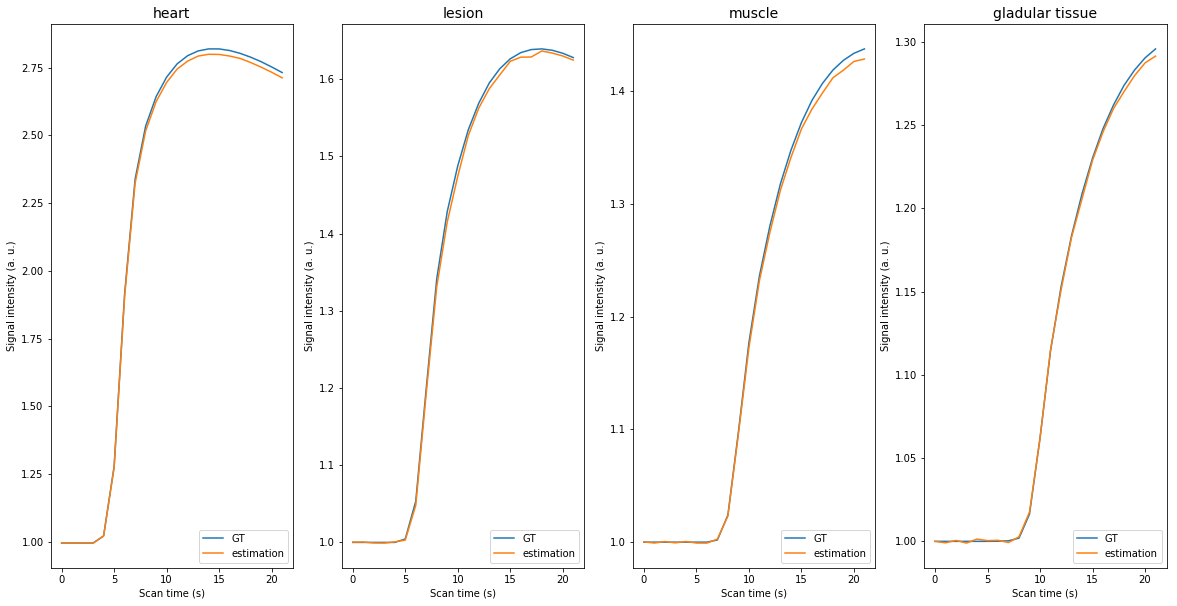

In [14]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_21.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 32,
            optimizer = 'CG5', 
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

torch.Size([22, 2, 320, 320])


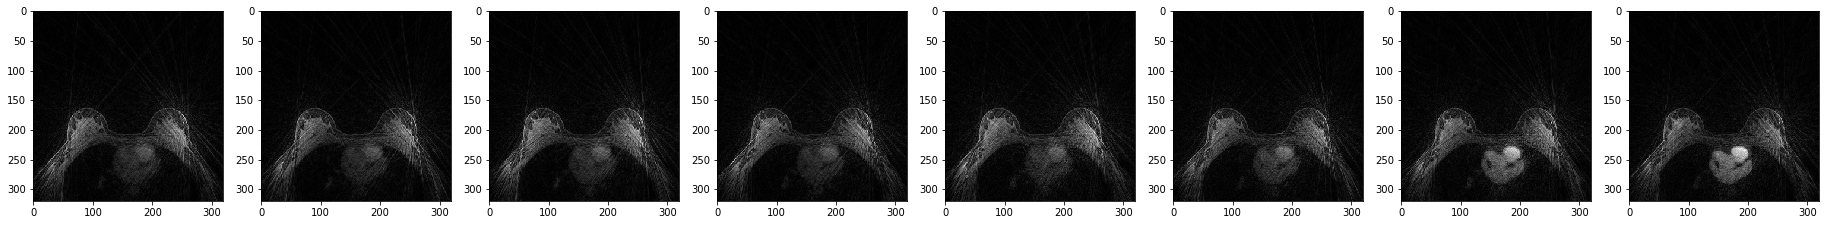

(22,)


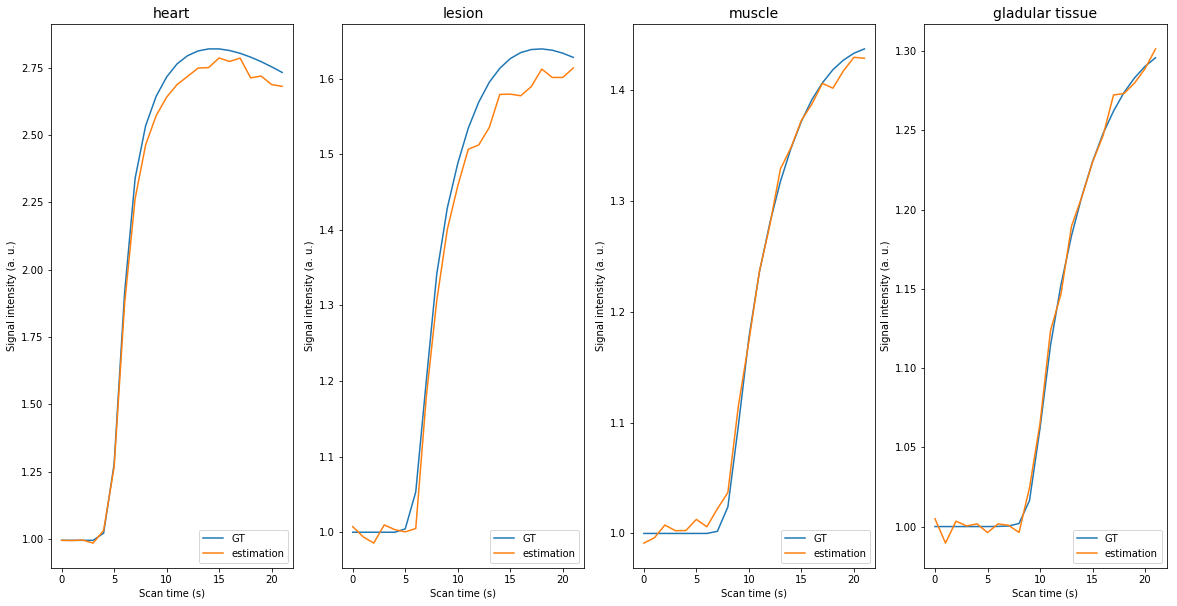

In [15]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_21.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Test with Malignant Case

dict_keys(['__header__', '__version__', '__globals__', 'ID', 'S0', 'aif', 'cts', 'mask', 'parMap', 'simImg', 'smap_complex'])


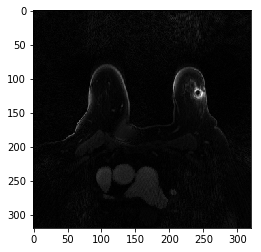

In [16]:
filedir = '/gpfs/home/zh1115/knolllabspace/hzn/storage/newsimulation/simulated_20210128/sim_BC33'
dataload = loadmat(filedir)
print(dataload.keys())

plt.imshow(np.abs(dataload['simImg'][:, :, 9]), cmap = 'gray')
plt.show()

In [17]:
masksloaded = dataload['mask']

simulated_image = dataload['simImg']
simulated_image = np.flipud(np.array(simulated_image))#flip up and down

simulated_target = np.array(simulated_image, dtype='complex128')
simulated_target = simulated_target.swapaxes(0, 2).swapaxes(1, 2)
#print(simulated_target.shape, simulated_target.dtype)

target = np.stack((simulated_target.real, simulated_target.imag), axis=1)
target = torch.tensor(target, dtype=dtype, device=device)

smap_complex = dataload['smap_complex']
smap_loaded = numpy2torch(smap_complex, device =device)
smap_loaded = smap_loaded.permute(1,0,2,3).unsqueeze(0)

nt = 22
temporal_coilimg = np.array([sim_coil(simulated_target[i,:,:], smap_complex, coild=0) for i in range(nt)])

target_recombine= np.array([temporal_coilimg[:,i]*np.conj(smap_complex[i,:,:]) for i in range(temporal_coilimg.shape[1])])
target_recombine= np.sum(target_recombine, axis=0)

print("target.shape", target.shape, target.dtype,\
      "smap.shape", smap_loaded.shape, smap_loaded.dtype)

simulated_kspace_21, recon_fromsim_21, traj_21, dcomp_21 \
= RadialSimulation(target = target,
                   spokespertime=21,
                   nt=nt, nc=16,
                   spokelength=640,
                   smap=smap_loaded,
                   grid_size = (640, 640),
                   im_size= (320, 320))

recon_fromsim_21 = torch2numpy(recon_fromsim_21.permute(0,2,3,1))

target.shape torch.Size([22, 2, 320, 320]) torch.float32 smap.shape torch.Size([1, 16, 2, 320, 320]) torch.float32
torch.Size([22, 16, 2, 13440])
torch.Size([22, 16, 2, 13440])
torch.Size([22, 2, 320, 320])


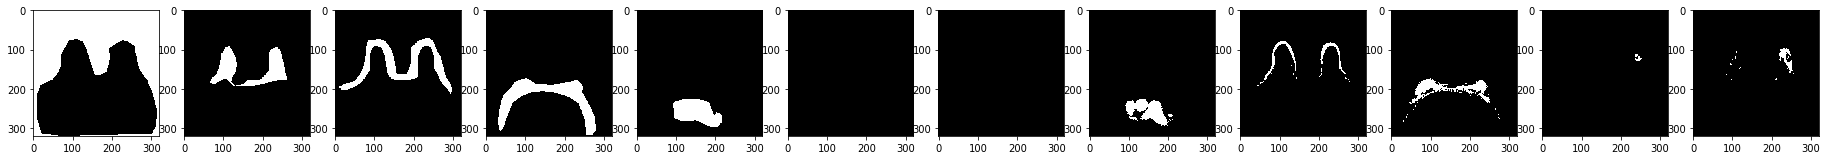

In [18]:
plotcoil(masksloaded[0][0], n = 12, cmap = 'gray')

In [19]:
def dcomp_reference(traj, nt = 22, nc = 1):
    dcomp = torch.sqrt(traj[0, 0]**2 + traj[0, 1]**2)
    dcomp = dcomp / max(dcomp)
    dcomp = dcomp.repeat(nt, nc, 2, 1)
    return dcomp

dcomp_FL = dcomp_reference(traj_21, nt = 22, nc = 16)
print(dcomp_FL.shape, dcomp_FL.device)

torch.Size([22, 16, 2, 13440]) cpu


## Adjoint NUFFT, Updated Density Compensation

torch.Size([22, 2, 320, 320])


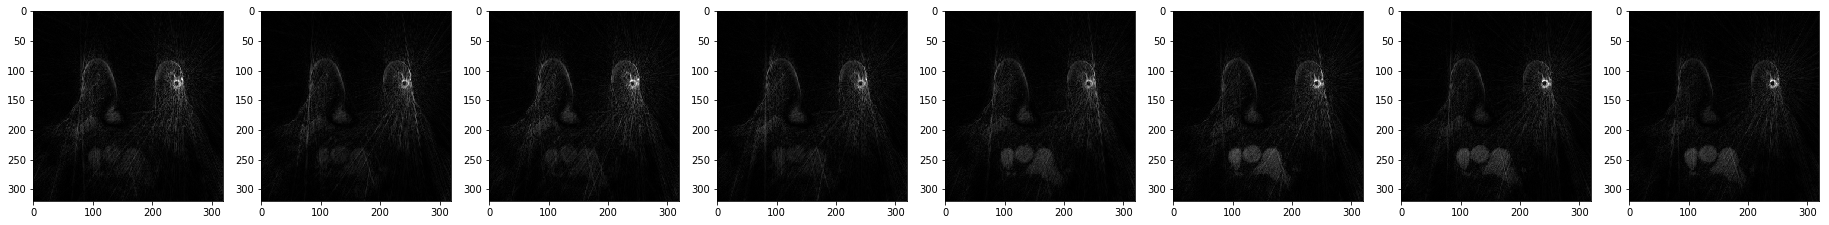

(22,)


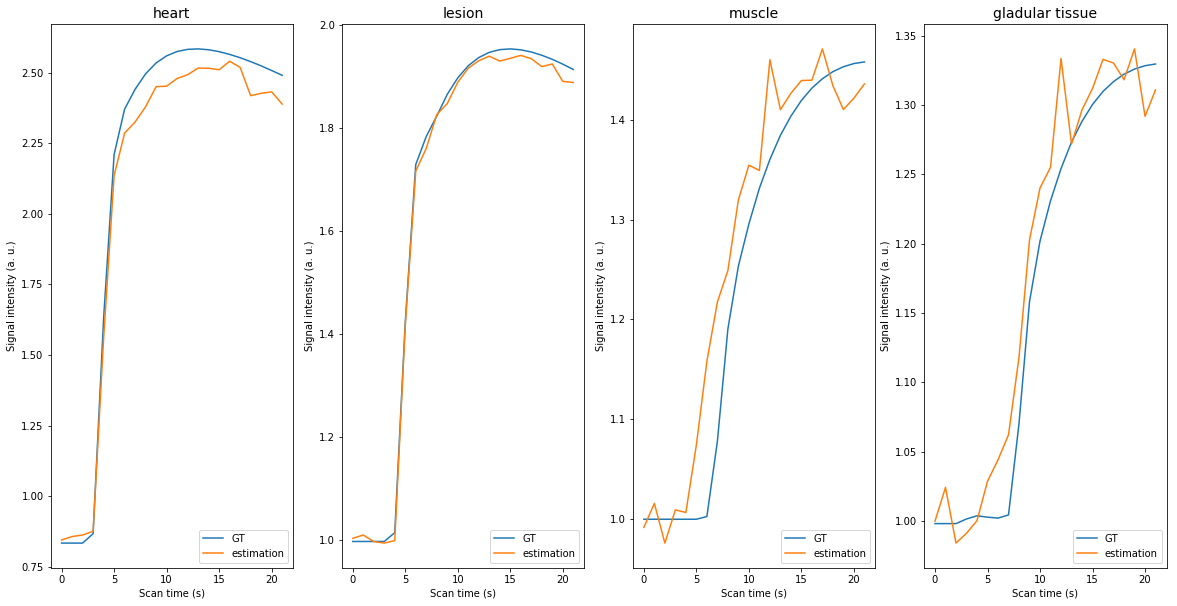

In [20]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_FL.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_FL.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## CG-SENSE, 128 steps

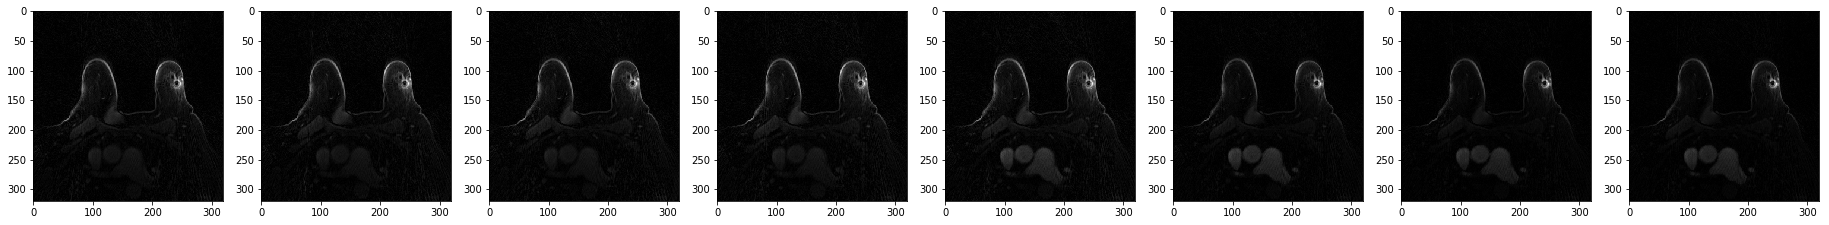

(22,)


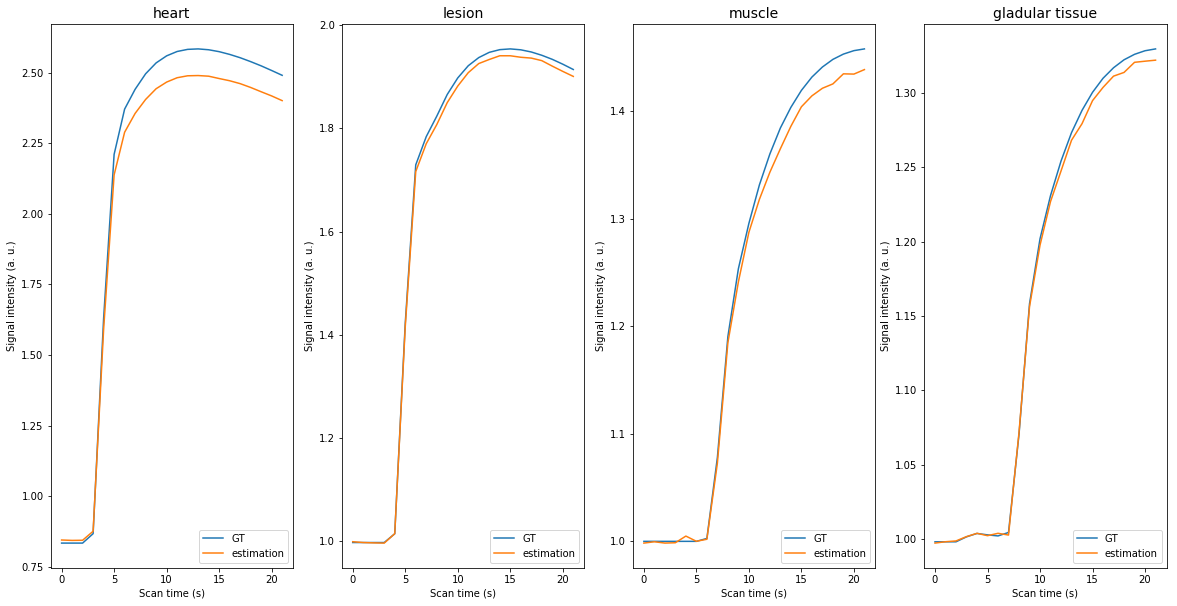

In [21]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5',
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## CG-SENSE, 640 steps

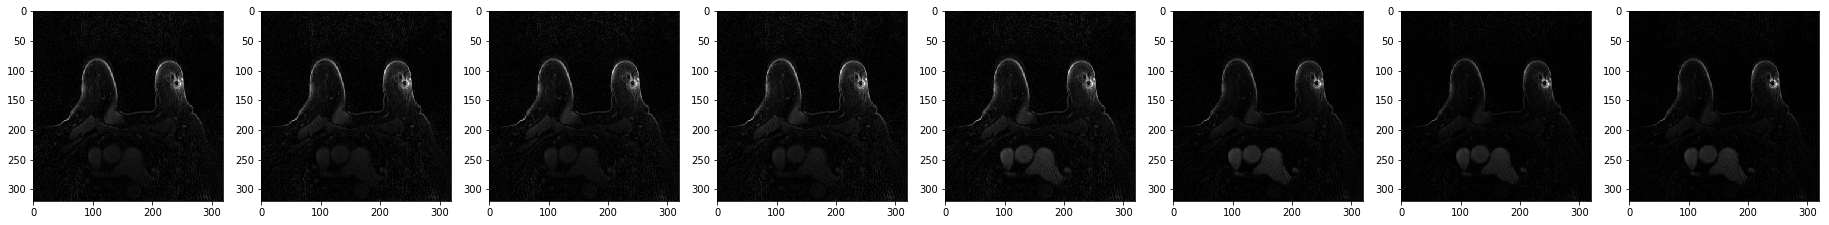

(22,)


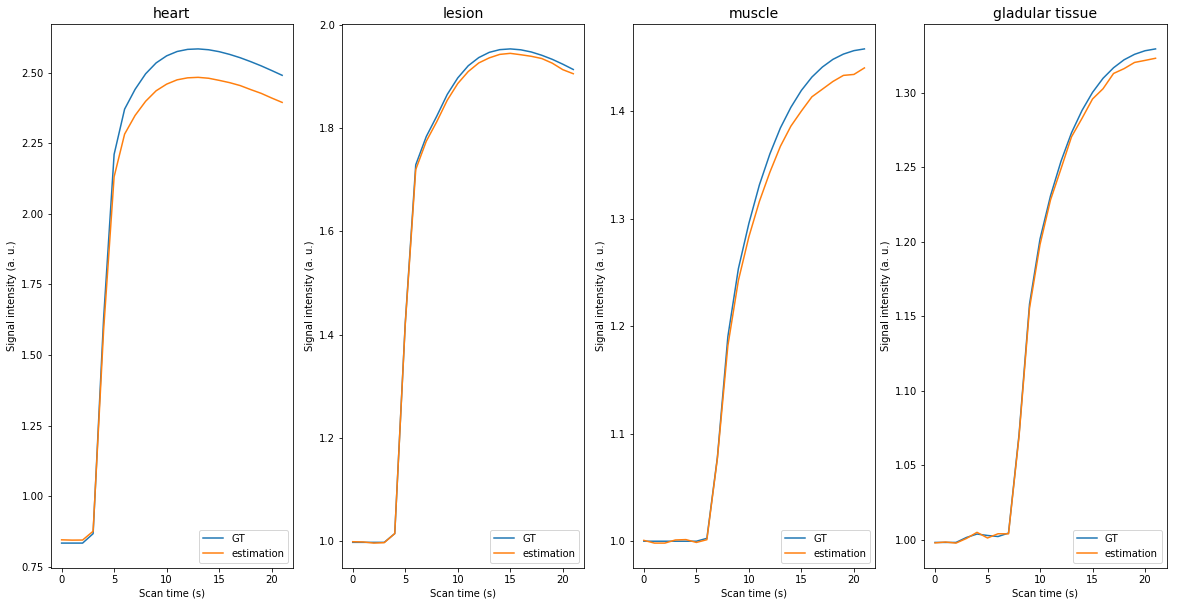

In [22]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_FL.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5',
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

## Original Density Compensation

torch.Size([22, 2, 320, 320])


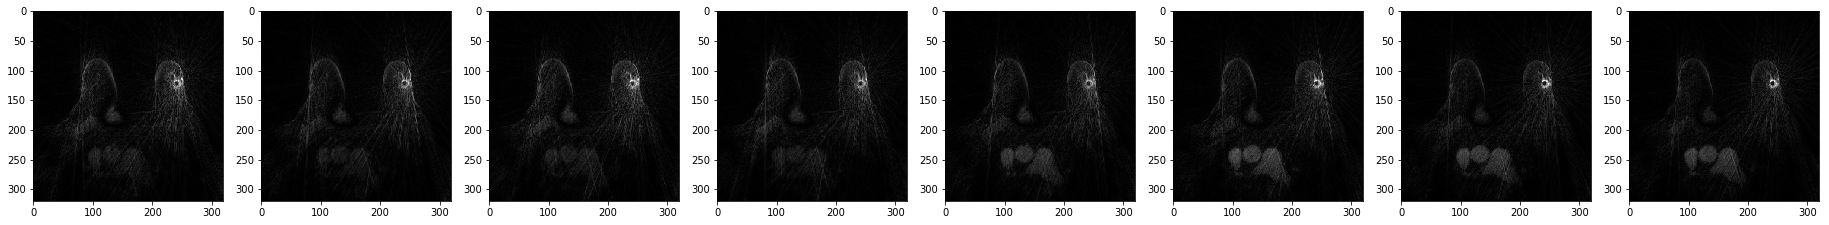

(22,)


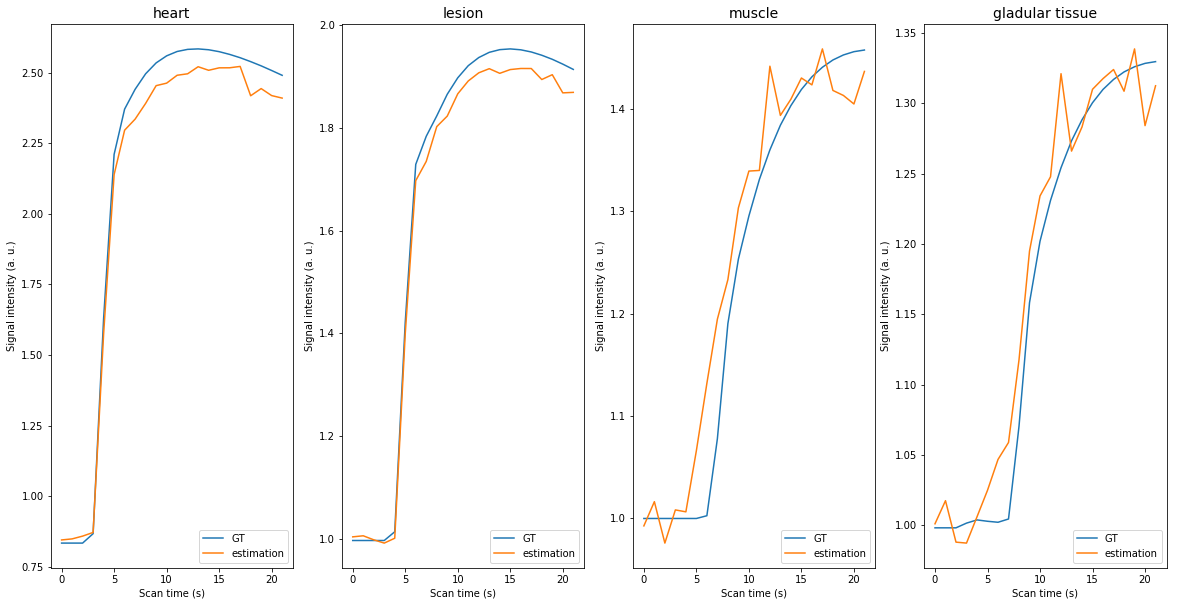

In [23]:
radialmodel = RadialModel(grid_size= (640, 640), im_size= (320, 320)).to(device, dtype)
adj_nufft_FLdcomp = radialmodel.adjoint(y = simulated_kspace_21.to(device) * torch.sqrt(dcomp_21.to(device)),
                    k = traj_21.to(device), 
                    coil_sensitivities = smap_loaded, 
                    w = dcomp_21.to(device))

print(adj_nufft_FLdcomp.shape)
adjnufft_FLdcomp = torch.sqrt(adj_nufft_FLdcomp[:, 0]**2 + adj_nufft_FLdcomp[:, 1]**2).cpu()
plotcoil(np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:])

plotcurves(x_hat = np.abs(adjnufft_FLdcomp.cpu().numpy())[:,::-1,:], 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

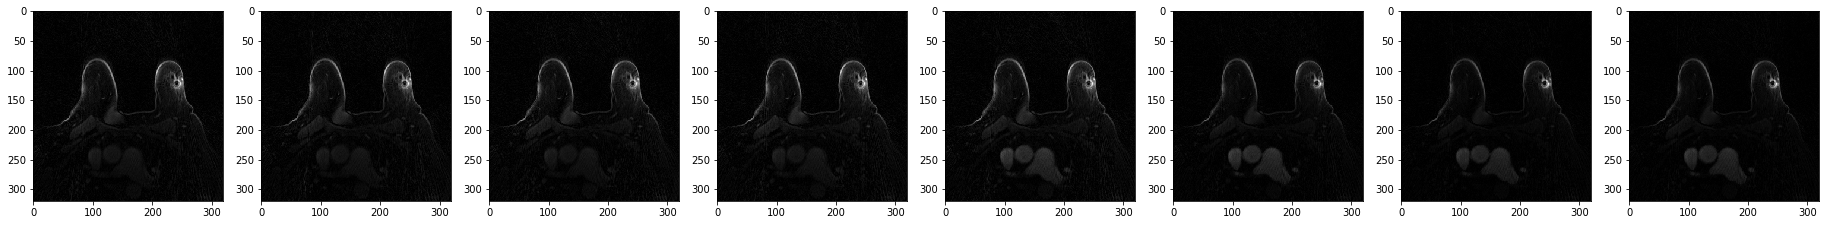

(22,)


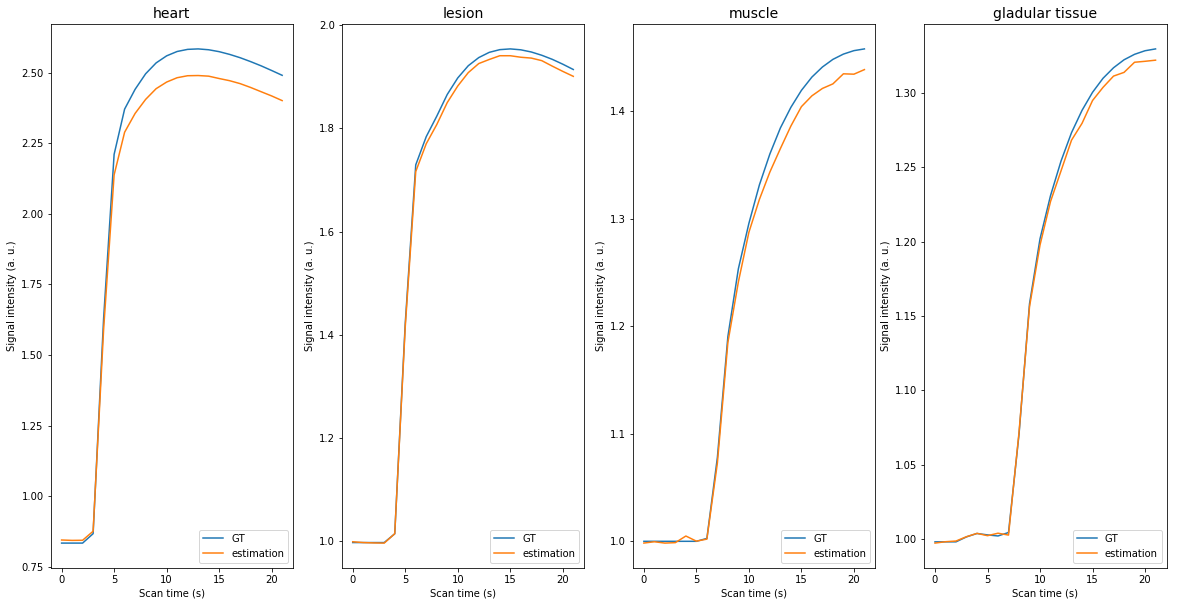

In [25]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_21.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 128,
            optimizer = 'CG5', 
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

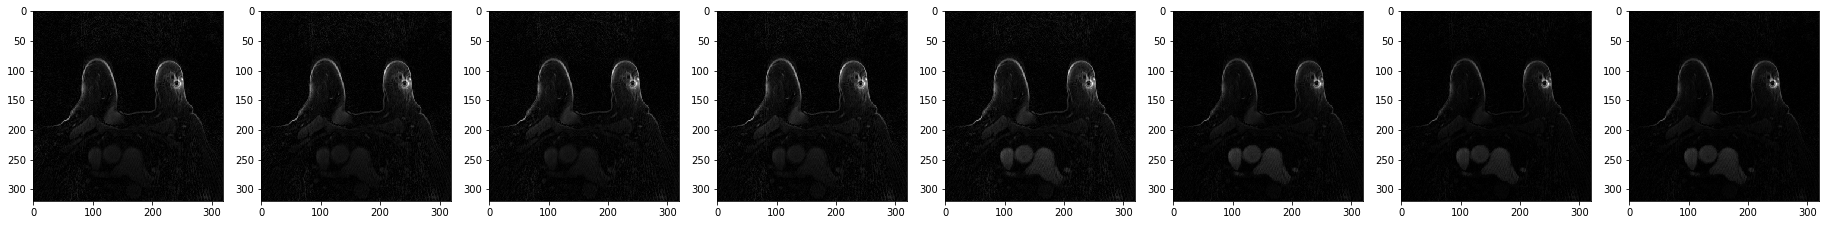

(22,)


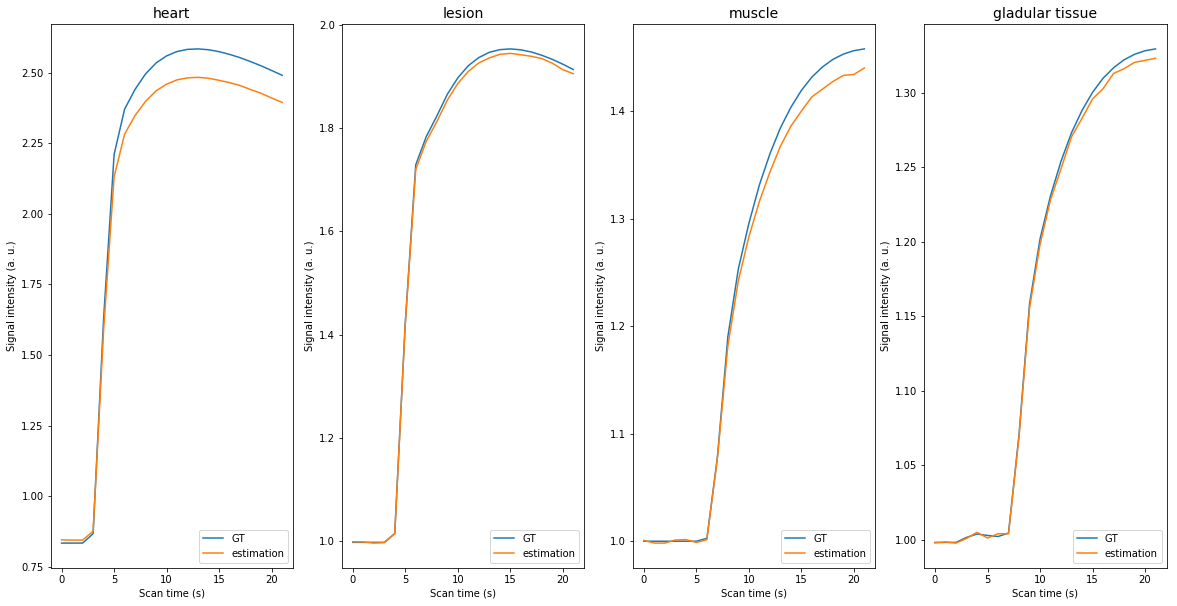

In [26]:
CG_recon, nufft_recon = \
RadialRecon_alternative(kspace= simulated_kspace_21.to(device), 
            traj = traj_21.to(device), 
            coil_sensitivities= smap_loaded, 
            w = dcomp_21.to(device), 
            grid_size = (640, 640),
            im_size = (320, 320), 
            tolerance = 1e-10,
            lambda1 = None,
            niter = 640,
            optimizer = 'CG5',
            verbose = False)

CG_recon_complex = CG_recon[:,0] + 1j * CG_recon[:,0]
plotcoil(np.abs(CG_recon_complex)[:,::-1,:])

plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_recombine[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)

In [27]:
target_numpy = torch2numpy(target, complexdim= 1)

(22,)


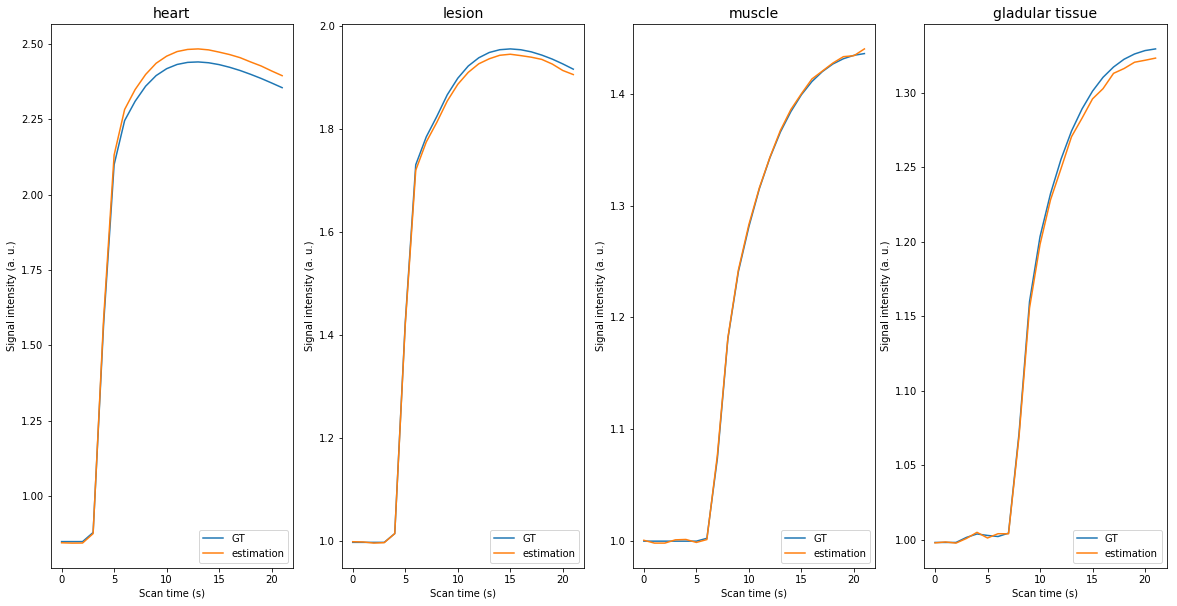

In [28]:
plotcurves(x_hat = np.abs(CG_recon_complex[:,::-1,:]), 
           x_gt = target_numpy[:,::-1,:], 
           maskdict = {'heart': masksloaded[0][0][4],
                       'lesion': masksloaded[0][0][10],
                       'muscle': masksloaded[0][0][9],
                       'gladular tissue': masksloaded[0][0][11]},
           names = ['estimation', 'GT'], 
           normalize = True)